In [0]:



%matplotlib inline


from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import warnings
# filter warnings
warnings.filterwarnings('ignore')

from subprocess import check_output

# Import various componenets for model building
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop

# Import the backend
from keras import backend as K

import numpy as np
import cv2
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import glob
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.cluster import KMeans

Objective: build a model predicting users’ demographic characteristics based on their app usage, geolocation, and cell phone properties. Furthermore, the goal is to aid developers and marketers engage in data-driven efforts that are relevant to and personalized to their end users preferences.

# Processing the data

In this first section I will read in the Talkingdata using the Kaggle API in addtion to preparing the data to be visualized and modeled 

In [12]:
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"gailyn","key":"f838642402b2c5fc90e6d2d0e8d7b171"}'}

In [13]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 62 Nov 22 18:03 kaggle.json


In [0]:
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so moving it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [16]:
!kaggle competitions download -c talkingdata-mobile-user-demographics

  0% 0.00/1.05M [00:00<?, ?B/s]
100% 1.05M/1.05M [00:00<00:00, 73.0MB/s]
  0% 0.00/4.04M [00:00<?, ?B/s]
100% 4.04M/4.04M [00:00<00:00, 37.2MB/s]
  0% 0.00/7.67k [00:00<?, ?B/s]
100% 7.67k/7.67k [00:00<00:00, 6.78MB/s]
  0% 0.00/2.42M [00:00<?, ?B/s]
100% 2.42M/2.42M [00:00<00:00, 165MB/s]
  0% 0.00/1.32M [00:00<?, ?B/s]
100% 1.32M/1.32M [00:00<00:00, 189MB/s]
 92% 57.0M/62.2M [00:01<00:00, 38.7MB/s]
100% 62.2M/62.2M [00:01<00:00, 47.7MB/s]
 99% 210M/211M [00:03<00:00, 60.6MB/s]
100% 211M/211M [00:03<00:00, 62.0MB/s]
  0% 0.00/891k [00:00<?, ?B/s]
100% 891k/891k [00:00<00:00, 124MB/s]


In [17]:
!ls 


 app_events.csv.zip	    kaggle.json
 app_labels.csv.zip	    label_categories.csv.zip
 events.csv.zip		    phone_brand_device_model.csv.zip
 gender_age_test.csv.zip    sample_data
 gender_age_train.csv.zip   sample_submission.csv.zip
'kaggle (1).json'


In [0]:
import zipfile

# Unzipping all of the files to gain acess to csv for each subset 
with zipfile.ZipFile('app_events.csv.zip', 'r') as zip_ref:
  zip_ref.extractall('app_events.csv')

with zipfile.ZipFile('app_labels.csv.zip', 'r') as zip_ref:
  zip_ref.extractall('app_labels.csv')

with zipfile.ZipFile('events.csv.zip', 'r') as zip_ref:
  zip_ref.extractall('events.csv')

with zipfile.ZipFile('gender_age_test.csv.zip', 'r') as zip_ref:
  zip_ref.extractall('gender_age_test.csv')

with zipfile.ZipFile('gender_age_train.csv.zip', 'r') as zip_ref:
  zip_ref.extractall('gender_age_train.csv')

with zipfile.ZipFile('label_categories.csv.zip', 'r') as zip_ref:
  zip_ref.extractall('label_categories.csv')

with zipfile.ZipFile('phone_brand_device_model.csv.zip', 'r') as zip_ref:
  zip_ref.extractall('phone_brand_device_model.csv')


In [0]:
apps = pd.read_csv(('app_events.csv/app_events.csv'),usecols=['event_id','app_id','is_active'], dtype={'is_active':bool})

gendertest = pd.read_csv('gender_age_test.csv/gender_age_test.csv')
gendertrain = pd.read_csv(('gender_age_train.csv/gender_age_train.csv'),index_col='device_id')

phone = pd.read_csv('phone_brand_device_model.csv/phone_brand_device_model.csv')
# Get rid of duplicate device ids in phone
phone = phone.drop_duplicates('device_id',keep='first')

app_labels = pd.read_csv('app_labels.csv/app_labels.csv')
events = pd.read_csv(('events.csv/events.csv'), usecols = ['event_id', 'device_id'])
labelcats = pd.read_csv(('label_categories.csv/label_categories.csv'),index_col='label_id',squeeze=True)



# Exploration 

In [20]:
gendertrain

,gender,age,group
device_id,,,
-8076087639492063270,M,35,M32-38
-2897161552818060146,M,35,M32-38
-8260683887967679142,M,35,M32-38
-4938849341048082022,M,30,M29-31
245133531816851882,M,30,M29-31
...,...,...,...
4682031842235089751,M,30,M29-31
-9178703742877135986,M,30,M29-31
180946546684162312,M,20,M22-


In [21]:
gendertest

,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277
3,-6220210354783429585
4,-5893464122623104785
...,...
112066,4280900819321920929
112067,818534825520551359
112068,-8956851351560395765
112069,6097318236795836256


In [22]:
apps

,event_id,app_id,is_active
0,2,5927333115845830913,True
1,2,-5720078949152207372,False
2,2,-1633887856876571208,False
3,2,-653184325010919369,True
4,2,8693964245073640147,True
...,...,...,...
32473062,3252948,6607018907660377991,True
32473063,3252948,6602285879264922467,True
32473064,3252948,4348659952760821294,True
32473065,3252948,-995726944612374565,True


In [23]:
phone

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2
...,...,...,...
187239,3210973037848940984,小米,MI 2S
187240,7979541072208733273,小米,MI 4
187241,-187404680852357705,小米,红米2
187242,-2718274279595622821,小米,MI 3


In [24]:
app_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459943 entries, 0 to 459942
Data columns (total 2 columns):
app_id      459943 non-null int64
label_id    459943 non-null int64
dtypes: int64(2)
memory usage: 7.0 MB


In [25]:
labelcats

label_id
1                       NaN
2            game-game type
3          game-Game themes
4            game-Art Style
5         game-Leisure time
               ...         
1017    Heritage Foundation
1018         Direct Banking
1019    Internet Securities
1020       Bank Credit Card
1021     Internet Insurance
Name: category, Length: 930, dtype: object

## Visualizations

## Age



> The age of the users skews towards the younger side with the most active users being in their 20s, despite the average age represented is 31



In [26]:
gendertrain.describe()

,age
count,74645.000000
mean,31.410342
std,9.868735
min,1.000000
25%,25.000000
50%,29.000000
75%,36.000000
max,96.000000


In [27]:
print(gendertrain.age.mode())
print(gendertrain.age.min())
print(gendertrain.age.max())
print(gendertrain.age.median())

0    26
dtype: int64
1
96
29.0


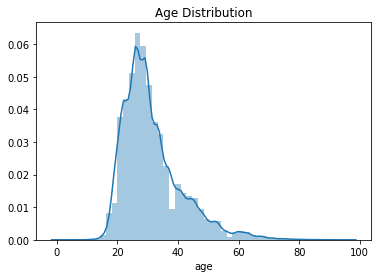

In [28]:
plt.title('Age Distribution')
#genderTrain.gender
sns.distplot(gendertrain.age)

## Gender



> The dataset has a heavy empahsis on male users. When looking at category distribution, the most heavily populated categories are males 23 to 38. Overall when compaing in respective age groups the male users outnumber the female users.



Text(0.5, 0, 'Count')

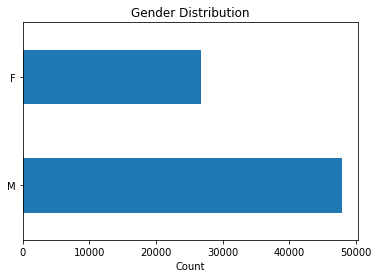

In [29]:
gendertrain.gender.value_counts().plot(kind='barh')
plt.title('Gender Distribution')
plt.xlabel('Count')

Text(0.5, 0, 'Individuals')

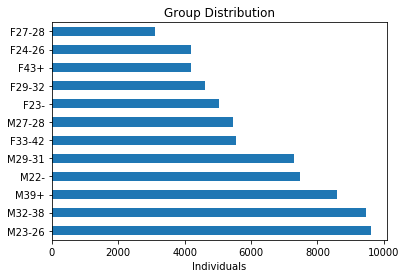

In [30]:
gendertrain.group.value_counts().plot(kind='barh')
plt.title('Group Distribution')
plt.xlabel('Individuals')

## App Usage

Text(0.5, 0, 'Count')

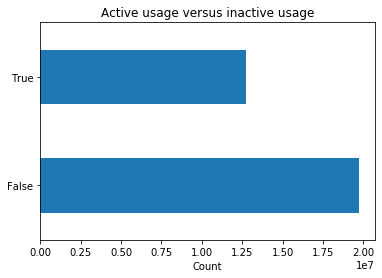

In [31]:
apps.is_active.value_counts().plot(kind='barh')
plt.title('Active usage versus inactive usage')
plt.xlabel('Count')

# Merging the subsets of the data


In [32]:
app_merge = pd.read_csv('app_events.csv/app_events.csv', usecols=['event_id','app_id','is_active'])
device_b = (
    app_merge
    
     # Merge on event_id
    .merge(events, how = 'left', left_on = 'event_id', right_on = 'event_id')
    
     # event_id itself is not interesting
    .drop('event_id', axis = 1)
    
     # Because the events correspond to more than just
     # being installed, there are many duplicates
    .drop_duplicates()
)

# Our data now looks like this
device_b.head()

,app_id,is_active,device_id
0,5927333115845830913,1,-6401643145415154744
1,-5720078949152207372,0,-6401643145415154744
2,-1633887856876571208,0,-6401643145415154744
3,-653184325010919369,1,-6401643145415154744
4,8693964245073640147,1,-6401643145415154744


In [0]:
# Combine the two columns
phone['brand_and_model'] = phone['phone_brand'].astype(str) + phone['device_model']

# Build numerical labels for our models
model_encoder = LabelEncoder().fit(phone['brand_and_model'])

# Store in a new column
phone['encoded_model'] = model_encoder.transform(phone['brand_and_model'])

In [0]:
events.head()

,event_id,device_id
0,1,29182687948017175
1,2,-6401643145415154744
2,3,-4833982096941402721
3,4,-6815121365017318426
4,5,-5373797595892518570


In [34]:
 # Adding labels to app_events
apps_labeled = pd.merge(app_labels,
                       apps[['app_id', 'is_active']],
                       on='app_id').dropna().drop_duplicates()

print(apps_labeled.shape)
apps_labeled.head()

(117374, 3)


,app_id,label_id,is_active
0,7324884708820027918,251,False
6,7324884708820027918,251,True
11,7324884708820027918,691,False
17,7324884708820027918,691,True
22,7324884708820027918,751,False


In [35]:
# Merge gendertrain and device_b
gt_device = pd.merge(gendertrain,
                  device_b[['app_id', 'is_active', 'device_id']],
                  on='device_id').dropna().drop_duplicates()
#Shape of ga_apps
print(gt_device.shape)

# Show how the new df looks.
gt_device.head()

(1097150, 6)


,device_id,gender,age,group,app_id,is_active
0,-8260683887967679142,M,35,M32-38,4287147352639325907,0
1,-8260683887967679142,M,35,M32-38,-4085686983594738208,0
2,-8260683887967679142,M,35,M32-38,6324194957022958681,0
3,-8260683887967679142,M,35,M32-38,-8687507491028761317,0
4,-8260683887967679142,M,35,M32-38,877288515501232570,1


In [36]:
# Merge the previous data set with brands now. 
gt_phoneapps = pd.merge(gt_device,
                         phone[['device_id', 'encoded_model']],
                         on='device_id').dropna().drop_duplicates()

print(gt_phoneapps.shape)

#Look at how the data looks.
gt_phoneapps.head()

(1097150, 7)


,device_id,gender,age,group,app_id,is_active,encoded_model
0,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843
1,-8260683887967679142,M,35,M32-38,-4085686983594738208,0,843
2,-8260683887967679142,M,35,M32-38,6324194957022958681,0,843
3,-8260683887967679142,M,35,M32-38,-8687507491028761317,0,843
4,-8260683887967679142,M,35,M32-38,877288515501232570,1,843


In [37]:

# Putting all of the data sets together.
gender_full = pd.merge(gt_phoneapps,
                                 apps_labeled[['app_id', 'label_id']],
                                 on='app_id').dropna().drop_duplicates()

print(gender_full.shape)

#Look at how the data looks.
gender_full.head()

(7034111, 8)


,device_id,gender,age,group,app_id,is_active,encoded_model,label_id
0,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843,713
2,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843,704
4,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843,548
6,8761770737926125955,F,22,F23-,4287147352639325907,0,226,713
8,8761770737926125955,F,22,F23-,4287147352639325907,0,226,704


In [38]:
# feature engineering
# Convert gender into a binary output
gender_full['gender'] = gender_full['gender'].apply(lambda x: 1 if x == 'M' else 0 )
gender_full.gender.value_counts()

1    4942458
0    2091653
Name: gender, dtype: int64

In [40]:

# Make another copy since the previous copy has already been dummified.
# Putting all of the data sets together.
gender_full_copy = pd.merge(gt_phoneapps,
                                 apps_labeled[['app_id', 'label_id']],
                                 on='app_id').dropna().drop_duplicates()

# Convert gender into a binary output
gender_full_copy ['gender'] = gender_full_copy['gender'].apply(lambda x: 1 if x == 'M' else 0 )

#Show me the shape
print(gender_full_copy.shape)

#Look at how the data looks.
gender_full_copy.head()

(7034111, 8)


,device_id,gender,age,group,app_id,is_active,encoded_model,label_id
0,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,713
2,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,704
4,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,548
6,8761770737926125955,0,22,F23-,4287147352639325907,0,226,713
8,8761770737926125955,0,22,F23-,4287147352639325907,0,226,704


In [41]:

# Convert label_id into a continuous variable
# even though it's numerical, it hasn't been standardized 
type_dummies = pd.get_dummies(gender_full['label_id'])

# Concatenate the dummies with the original data set.
gender_full = pd.concat([gender_full, type_dummies], axis=1)

print(gender_full.shape)

gender_full.head()

(7034111, 493)


,device_id,gender,age,group,app_id,is_active,encoded_model,label_id,2,4,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,38,...,973,974,975,976,977,978,980,982,983,984,986,987,988,990,991,993,995,996,997,998,999,1002,1003,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
0,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,704,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,548,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,8761770737926125955,0,22,F23-,4287147352639325907,0,226,713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,8761770737926125955,0,22,F23-,4287147352639325907,0,226,704,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
gender_full.group.value_counts()


M32-38    1185421
M39+      1107632
M23-26     817660
M29-31     810956
M27-28     530780
F33-42     517420
M22-       490009
F43+       391188
F29-32     368450
F23-       303034
F24-26     265262
F27-28     246299
Name: group, dtype: int64

In [0]:
# Downsampling the gender/age training set to 50000.
#ga_m_youngest = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M22-']
cat1=gender_full[gender_full.group=='M22-']
cat1_downsampled = resample(cat1,replace=True,n_samples=30000)
cat2= gender_full[gender_full.group=='M23-26']
cat2_downsampled = resample(cat2,replace=True,n_samples=30000)
cat3 = gender_full[gender_full.group=='M27-28']
cat3_downsampled = resample(cat3, replace=True, n_samples=30000) 

cat4 = gender_full[gender_full.group=='M29-31']
cat4_downsampled = resample(cat4,replace=True, n_samples=30000)
cat5 = gender_full[gender_full.group=='M32-38']
cat5_downsampled = resample(cat5, replace=True,  n_samples=30000)

cat6 = gender_full[gender_full.group=='M39+']
cat6_downsampled = resample(cat6, replace=True, n_samples=30000)

# Downsample majority class


In [0]:

cat7 = gender_full[gender_full.group=='F23-']
cat7_downsampled = resample(cat7, replace=True, n_samples=30000)

cat8 = gender_full[gender_full.group=='F24-26']
cat8_downsampled = resample(cat8, replace=True, n_samples=30000)

cat9 = gender_full[gender_full.group=='F27-28']
cat9_downsampled = resample(cat9, replace=True, n_samples=30000)
cat10 = gender_full[gender_full.group=='F29-32']
cat10_downsampled = resample(cat10, replace=True, n_samples=30000)
cat11 = gender_full[gender_full.group=='F33-42']
cat11_downsampled = resample(cat11, replace=True,n_samples=30000)
cat12 = gender_full[gender_full.group=='F43+']
cat12_downsampled = resample(cat12, replace=True, n_samples=30000)

In [46]:

# Combine downsampled majority class 
gender_full_sampled = pd.concat([cat1_downsampled,cat2_downsampled,
                               cat3_downsampled,cat4_downsampled,
                               cat5_downsampled, cat6_downsampled,
                               cat7_downsampled, cat8_downsampled,
                               cat9_downsampled, cat10_downsampled,
                              cat11_downsampled, cat12_downsampled])
 
# Display new class counts
gender_full_sampled.group.value_counts()

M29-31    30000
F23-      30000
F27-28    30000
M23-26    30000
M22-      30000
F29-32    30000
F24-26    30000
M27-28    30000
F33-42    30000
M39+      30000
F43+      30000
M32-38    30000
Name: group, dtype: int64

# Using PCA

In [0]:
# PCA 
# PCA for 10 components 
from sklearn.decomposition import PCA
X = gender_full_sampled.drop(['group'], axis=1)
y = gender_full_sampled['group'].values

# Use PCA to create new columns 
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(X)
pca_X = pd.DataFrame(data = principalComponents, 
                     columns = ['principal component 1', 'principal component 2', 'principal component 3', 
                                'principal component 4','principal component 5','principal component 6', 
                               'principal component 7', 'principal component 8','principal component 9','principal component 10'])

### Naive Bayes

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split


# Instantiate our model and Fit our model to the data.
bnb = BernoulliNB()
bnb.fit(pca_X, y)

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(pca_X,y, test_size=0.3, random_state=200)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(pca_X, y).score(pca_X, y)))

# Cross validating using 10 folds  
from sklearn.model_selection import cross_val_score
print(cross_val_score(bnb,pca_X , y, cv=10))

#Classification report 
from sklearn.metrics import classification_report
print('Native Bayes Classification report :')
print(classification_report(y_test, bnb.predict(X_test)))



With 20% Holdout: 0.3544888888888889
Testing on Sample: 0.3542533333333333
[0.3504     0.3532     0.353      0.35773333 0.35246667 0.3532
 0.35133333 0.35653333 0.35276667 0.35376667]
Native Bayes Classification report :
              precision    recall  f1-score   support

        F23-       0.30      0.38      0.33      7397
      F24-26       0.29      0.25      0.26      7514
      F27-28       0.27      0.46      0.34      7405
      F29-32       0.00      0.00      0.00      7628
      F33-42       0.49      0.49      0.49      7603
        F43+       0.47      0.59      0.53      7425
        M22-       0.27      0.34      0.30      7505
      M23-26       0.27      0.15      0.19      7499
      M27-28       0.26      0.50      0.34      7621
      M29-31       0.27      0.05      0.09      7466
      M32-38       0.51      0.55      0.53      7529
        M39+       0.52      0.51      0.51      7408

    accuracy                           0.35     90000
   macro avg       0.

### Random Forest

In [0]:
# Model 3: Random Forest gridsearchcv  took 300 min 
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
rfc = ensemble.RandomForestClassifier()



param_grid = { 
    'n_estimators': [15, 200, 500],
    'max_features': [7,8,9,10],
    'max_depth': [6,7,8]
}


grid = GridSearchCV(rfc, param_grid, cv=2, verbose=3, n_jobs=-1)

grid.fit(pca_X,y)

# Show the best parameter and best score 
print(grid.best_params_)
print( grid.best_score_)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 94.3min finished


{'max_depth': 8, 'max_features': 8, 'n_estimators': 15}
0.9924533333333333


In [0]:
# Random forest model using pca , 
from sklearn import ensemble
rfc = ensemble.RandomForestClassifier(n_estimators=15, max_features= 8, max_depth=8)


from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(pca_X, y ,test_size=0.2, random_state=100)
print('With 20% Holdout: ' + str(rfc.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(rfc.fit(pca_X, y).score(pca_X, y)))


# Cross validating using 10 folds  
from sklearn.model_selection import cross_val_score
print(cross_val_score(rfc, pca_X, y, cv=10))


from sklearn.metrics import classification_report
print('Random Forest report :')
print(classification_report(y_test, rfc.predict(X_test)))




With 20% Holdout: 0.9893833333333333
Testing on Sample: 0.9913766666666667
[0.9909     0.99023333 0.99256667 0.9897     0.99026667 0.99236667
 0.99196667 0.99056667 0.9912     0.99276667]
Random Forest report :
              precision    recall  f1-score   support

        F23-       1.00      0.99      1.00      4910
      F24-26       0.97      0.99      0.98      5058
      F27-28       0.97      0.97      0.97      4908
      F29-32       1.00      0.98      0.99      4981
      F33-42       1.00      1.00      1.00      5079
        F43+       1.00      1.00      1.00      5034
        M22-       1.00      1.00      1.00      5000
      M23-26       1.00      0.99      0.99      5073
      M27-28       0.98      1.00      0.99      4986
      M29-31       0.99      0.99      0.99      4937
      M32-38       1.00      1.00      1.00      5055
        M39+       1.00      1.00      1.00      4979

    accuracy                           0.99     60000
   macro avg       0.99      0.

## Decision Tree

In [0]:
# Decision Tree Gridsearch 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


# Initialize the model
decision_tree = DecisionTreeClassifier()

# Set parameters for dtc
params = [{'max_features': [7, 8, 9, 10],
             'max_depth': [ 6, 7,8]}]



# Search for the best paramters. 
decision_tree_grid = GridSearchCV(decision_tree, params, cv=2, verbose=1, n_jobs=-1)

# Fit the grid and obtain results
decision_tree_grid.fit(pca_X, y)

# Return best parameters and best score
print(decision_tree_grid.best_params_)
print(decision_tree_grid.best_score_)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   17.8s finished


{'max_depth': 8, 'max_features': 10}
0.9871


In [0]:
decision_tree = DecisionTreeClassifier( 
    criterion='entropy',
    max_features=10,
    max_depth=8)


from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(pca_X,y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(decision_tree.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(decision_tree.fit(pca_X, y).score(pca_X, y)))


# Cross validating using 10 folds  
from sklearn.model_selection import cross_val_score
print(cross_val_score(decision_tree, pca_X, y, cv=10))


from sklearn.metrics import classification_report
print('Decision Tree report :')
print(classification_report(y_test, decision_tree.predict(X_test)))

With 20% Holdout: 0.9982
Testing on Sample: 0.9977133333333333
[0.9976     0.9969     0.9977     0.9984     0.99776667 0.99736667
 0.99856667 0.99766667 0.99726667 0.99773333]
Decision Tree report :
              precision    recall  f1-score   support

        F23-       1.00      1.00      1.00      4988
      F24-26       0.99      1.00      0.99      4944
      F27-28       1.00      0.98      0.99      4900
      F29-32       0.99      1.00      1.00      4962
      F33-42       1.00      1.00      1.00      4973
        F43+       1.00      1.00      1.00      5041
        M22-       1.00      1.00      1.00      5022
      M23-26       1.00      1.00      1.00      5104
      M27-28       1.00      1.00      1.00      4970
      M29-31       1.00      1.00      1.00      5044
      M32-38       1.00      1.00      1.00      5037
        M39+       1.00      1.00      1.00      5015

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00

###Logistic Regression 

In [0]:
# Set up best parameters
lr3 = LogisticRegression(C=100, max_iter=25, multi_class='multinomial', solver='lbfgs')

# Fit the model
lr3.fit(X_train2, y_train2)

lr3.score(X_train2, y_train2)

In [0]:
# Set up best parameters
lr3 = LogisticRegression(C=1, max_iter=5, multi_class='multinomial', solver='lbfgs')

# Fit the model
lr3.fit(pca_X, y)

lr3.score(pca_X, y)

0.08736

In [0]:
from sklearn.model_selection import GridSearchCV
# Logistic Regression Gridsearch cv 
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = (0.01, 0.1, 1, 10, 100, 1000)

# Create hyperparameter options
parameters = dict(C=C, penalty=penalty)

# Use GS-CV to see which alpha level is best.

logr_grid = GridSearchCV(logr, parameters, cv=2, verbose=1)

#Fit the logistic regression 
logr_grid.fit(pca_X, y)

#return best parameters and best score

print(logr_grid.best_params_)
print(logr_grid.best_score_)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [0]:
# Logistic regression model 
logr = LogisticRegression(C= 10, penalty='l1')


logr.fit(pca_X,y)

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(pca_X, y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(logr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(logr.fit(pca_X, y).score(pca_X, y)))

# Cross validating using 10 folds  
from sklearn.model_selection import cross_val_score
print(cross_val_score(logr, pca_X, y, cv=3))

from sklearn.metrics import classification_report
print('Logistic regression report :')
print(classification_report(y_test, logr.predict(X_test)))


In [0]:
# Logistic regression model 
logr = LogisticRegression(C= 10, penalty='l1')


logr.fit(pca_X,y)

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(pca_X, y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(logr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(logr.fit(pca_X, y).score(pca_X, y)))

# Cross validating using 10 folds  
from sklearn.model_selection import cross_val_score
print(cross_val_score(logr, pca_X, y, cv=10))

from sklearn.metrics import classification_report
print('Logistic regression report :')
print(classification_report(y_test, logr.predict(X_test)))


### Gradient Boosting 

In [0]:
# Parameters to test in gridsearch cv 

params = {'n_estimators': [150, 200, 300, 500],
                           
          'max_depth': [5,6,7,8],
         }

# Initialize and fit the model.
gb = ensemble.GradientBoostingClassifier()

# Use the grid
gb_grid = GridSearchCV(gb, params, cv=2, verbose=1, n_jobs=-1)

# Fit the grid
gb_grid.fit(pca_X, y)

# Return best parameters and best score
print(gb_grid.best_params_)
print(gb_grid.best_score_)

In [0]:
# Gradient boosting model 
# Best Parameters from gridsearchcv 
params = {'n_estimators': 50,
          'max_depth': 6,
          'loss': 'deviance'}

# Initialize and fit the model.
gb = ensemble.GradientBoostingClassifier(**params)

gb.fit(pca_X,y)

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(pca_X,y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(gb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(gb.fit(pca_X, y).score(pca_X, y)))

# Cross validating using 10 folds  
from sklearn.model_selection import cross_val_score
print(cross_val_score(gb, pca_X, y, cv=2))

from sklearn.metrics import classification_report
print('Gradient Boosting report :')
print(classification_report(y_test, gb.predict(X_test)))



With 20% Holdout: 0.9995416666666667
Testing on Sample: 1.0
[0.9995     0.99948889]
Gradient Boosting report :
              precision    recall  f1-score   support

        F23-       1.00      1.00      1.00      5965
      F24-26       1.00      1.00      1.00      5851
      F27-28       1.00      1.00      1.00      5995
      F29-32       1.00      1.00      1.00      6045
      F33-42       1.00      1.00      1.00      5936
        F43+       1.00      1.00      1.00      5979
        M22-       1.00      1.00      1.00      6132
      M23-26       1.00      1.00      1.00      6006
      M27-28       1.00      1.00      1.00      6011
      M29-31       1.00      1.00      1.00      6004
      M32-38       1.00      1.00      1.00      6001
        M39+       1.00      1.00      1.00      6075

    accuracy                           1.00     72000
   macro avg       1.00      1.00      1.00     72000
weighted avg       1.00      1.00      1.00     72000



In [0]:
# Gradient boosting model 
# Best Parameters from gridsearchcv 
params = {'n_estimators': 25,
          'max_depth': 4,
          'loss': 'deviance'}

# Initialize and fit the model.
gb = ensemble.GradientBoostingClassifier(**params)

gb.fit(pca_X,y)

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(pca_X,y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(gb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(gb.fit(pca_X, y).score(pca_X, y)))

# Cross validating using 10 folds  
from sklearn.model_selection import cross_val_score
print(cross_val_score(gb, pca_X, y, cv=2))

from sklearn.metrics import classification_report
print('Gradient Boosting report :')
print(classification_report(y_test, gb.predict(X_test)))

With 20% Holdout: 0.9911111111111112
Testing on Sample: 0.9914222222222222
[0.98869444 0.98929444]
Gradient Boosting report :
              precision    recall  f1-score   support

        F23-       0.99      1.00      1.00      5965
      F24-26       0.98      0.99      0.99      5851
      F27-28       1.00      0.98      0.99      5995
      F29-32       0.99      0.99      0.99      6045
      F33-42       1.00      1.00      1.00      5936
        F43+       1.00      1.00      1.00      5979
        M22-       0.99      1.00      1.00      6132
      M23-26       0.98      0.98      0.98      6006
      M27-28       0.98      0.97      0.98      6011
      M29-31       0.99      0.99      0.99      6004
      M32-38       0.99      0.99      0.99      6001
        M39+       1.00      1.00      1.00      6075

    accuracy                           0.99     72000
   macro avg       0.99      0.99      0.99     72000
weighted avg       0.99      0.99      0.99     72000



In [0]:
# Gradient boosting model 
# Best Parameters from gridsearchcv 
params = {'n_estimators': 10,
          'max_depth': 4,
          'loss': 'deviance'}

# Initialize and fit the model.
gb = ensemble.GradientBoostingClassifier(**params)

gb.fit(pca_X,y)

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(pca_X,y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(gb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(gb.fit(pca_X, y).score(pca_X, y)))

# Cross validating using 10 folds  
from sklearn.model_selection import cross_val_score
print(cross_val_score(gb, pca_X, y, cv=3))

from sklearn.metrics import classification_report
print('Gradient Boosting report :')
print(classification_report(y_test, gb.predict(X_test)))

With 20% Holdout: 0.9401388888888889
Testing on Sample: 0.9408222222222222
[0.94481111 0.93969444]
Gradient Boosting report :
              precision    recall  f1-score   support

        F23-       0.99      1.00      0.99      5965
      F24-26       0.93      0.91      0.92      5851
      F27-28       0.87      0.82      0.84      5995
      F29-32       0.87      0.92      0.89      6045
      F33-42       0.95      0.98      0.97      5936
        F43+       1.00      1.00      1.00      5979
        M22-       0.99      1.00      1.00      6132
      M23-26       0.97      0.94      0.96      6006
      M27-28       0.90      0.87      0.88      6011
      M29-31       0.87      0.89      0.88      6004
      M32-38       0.94      0.97      0.96      6001
        M39+       1.00      1.00      1.00      6075

    accuracy                           0.94     72000
   macro avg       0.94      0.94      0.94     72000
weighted avg       0.94      0.94      0.94     72000



In [0]:
# Gradient boosting model 
# Best Parameters from gridsearchcv 
params = {'n_estimators': 5,
          'max_depth': 8,
          'loss': 'deviance'}

# Initialize and fit the model.
gb = ensemble.GradientBoostingClassifier(**params)

gb.fit(pca_X,y)

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(pca_X,y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(gb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(gb.fit(pca_X, y).score(pca_X, y)))

# Cross validating using 10 folds  
from sklearn.model_selection import cross_val_score
print(cross_val_score(gb, pca_X, y, cv=3))

from sklearn.metrics import classification_report
print('Gradient Boosting report :')
print(classification_report(y_test, gb.predict(X_test)))

With 20% Holdout: 0.9994583333333333
Testing on Sample: 0.9999666666666667
[0.9993     0.99929167 0.999325  ]
Gradient Boosting report :
              precision    recall  f1-score   support

        F23-       1.00      1.00      1.00      5965
      F24-26       1.00      1.00      1.00      5851
      F27-28       1.00      1.00      1.00      5995
      F29-32       1.00      1.00      1.00      6045
      F33-42       1.00      1.00      1.00      5936
        F43+       1.00      1.00      1.00      5979
        M22-       1.00      1.00      1.00      6132
      M23-26       1.00      1.00      1.00      6006
      M27-28       1.00      1.00      1.00      6011
      M29-31       1.00      1.00      1.00      6004
      M32-38       1.00      1.00      1.00      6001
        M39+       1.00      1.00      1.00      6075

    accuracy                           1.00     72000
   macro avg       1.00      1.00      1.00     72000
weighted avg       1.00      1.00      1.00     720

In [0]:
# Gradient boosting model 
# Best Parameters from gridsearchcv 
params = {'n_estimators': 5,
          'max_depth': 4,
          'loss': 'deviance'}

# Initialize and fit the model.
gb = ensemble.GradientBoostingClassifier(**params)

gb.fit(pca_X,y)

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(pca_X,y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(gb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(gb.fit(pca_X, y).score(pca_X, y)))

# Cross validating using 10 folds  
from sklearn.model_selection import cross_val_score
print(cross_val_score(gb, pca_X, y, cv=3))

from sklearn.metrics import classification_report
print('Gradient Boosting report :')
print(classification_report(y_test, gb.predict(X_test)))

With 20% Holdout: 0.9386944444444445
Testing on Sample: 0.9395083333333333
[0.94098333 0.938275   0.93901667]
Gradient Boosting report :
              precision    recall  f1-score   support

        F23-       0.99      1.00      0.99      5965
      F24-26       0.93      0.90      0.92      5851
      F27-28       0.87      0.81      0.84      5995
      F29-32       0.87      0.92      0.89      6045
      F33-42       0.95      0.98      0.97      5936
        F43+       1.00      1.00      1.00      5979
        M22-       0.99      1.00      0.99      6132
      M23-26       0.97      0.93      0.95      6006
      M27-28       0.89      0.87      0.88      6011
      M29-31       0.87      0.89      0.88      6004
      M32-38       0.94      0.97      0.96      6001
        M39+       1.00      1.00      1.00      6075

    accuracy                           0.94     72000
   macro avg       0.94      0.94      0.94     72000
weighted avg       0.94      0.94      0.94     720

### SVM

In [0]:

# SVM model using features 
from sklearn.svm import SVC
svm = SVC(C=.1, gamma=.01)


# AttributeError: predict_proba is not available when  probability=False -> ERROR FOR SVM AUC 


svm.fit(pca_X,y)

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(pca_X,y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(svm.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(svm.fit(pca_X, y).score(pca_X, y)))

# Cross validating using 10 folds  
from sklearn.model_selection import cross_val_score
print(cross_val_score(svm, pca_X,y, cv=5))

from sklearn.metrics import classification_report
print('SVM report :')
print(classification_report(y_test, svm.predict(X_test)))

In [0]:
# SVM model using features 
from sklearn.svm import SVC
svm = SVC(C=.1, gamma=.01)


# AttributeError: predict_proba is not available when  probability=False -> ERROR FOR SVM AUC 


svm.fit(pca_X,y)

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(pca_X,y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(svm.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(svm.fit(pca_X, y).score(pca_X, y)))

# Cross validating using 10 folds  
from sklearn.model_selection import cross_val_score
print(cross_val_score(svm, pca_X,y, cv=5))

from sklearn.metrics import classification_report
print('SVM report :')
print(classification_report(y_test, svm.predict(X_test)))

# Supervised methods uUsing Selectk Best

In [0]:

# selectKbest 
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

X = gender_full_sampled.drop(['group'], axis=1)
y = gender_full_sampled['group'].values

# Perform feature selection
selector = SelectKBest(f_classif, k=10)
selector.fit(X,y)

X_new = selector.transform(X)
X_new.shape
print(selector.get_support(indices=True))

# Most 10  useful cols 
X_new = selector.transform(X)
print(X_new.shape)
# Col names 
X.columns[selector.get_support(indices=True)]

[  1   2   4   5   6 174 276 445 446 477]
(360000, 10)


Index([       'gender',           'age',     'is_active', 'encoded_model',
            'label_id',             209,             706,             959,
                   960,            1007],
      dtype='object')

In [0]:
# creating data frame with our choosen features 
features = gender_full_sampled[['gender', 'age','is_active', 'encoded_model','label_id', 706,730, 959, 960,1007]]


### Random Forest

In [0]:
# Model 3: Random Forest gridsearchcv  took 300 min 
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
rfc = ensemble.RandomForestClassifier()



param_grid = { 
    'n_estimators': [15, 200, 500],
    'max_features': [7,8,9,10],
    'max_depth': [6,7,8]
}


grid = GridSearchCV(rfc, param_grid, cv=2, verbose=3, n_jobs=-1)

grid.fit(features,y)

# Show the best parameter and best score 
print(grid.best_params_)
print( grid.best_score_)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 11.8min finished


{'max_depth': 6, 'max_features': 7, 'n_estimators': 15}
1.0


In [0]:
# Random forest model using selectk best , 
from sklearn import ensemble
rfc = ensemble.RandomForestClassifier(n_estimators=15, max_features= 7, max_depth=6)


from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(features, y ,test_size=0.2, random_state=100)
print('With 20% Holdout: ' + str(rfc.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(rfc.fit(features, y).score(features, y)))


# Cross validating using 10 folds  
from sklearn.model_selection import cross_val_score
print(cross_val_score(rfc, features, y, cv=5))


from sklearn.metrics import classification_report
print('Random Forest report :')
print(classification_report(y_test, rfc.predict(X_test)))


With 20% Holdout: 1.0
Testing on Sample: 1.0
[1. 1. 1. 1. 1.]
Random Forest report :
              precision    recall  f1-score   support

        F23-       1.00      1.00      1.00      5932
      F24-26       1.00      1.00      1.00      6082
      F27-28       1.00      1.00      1.00      5975
      F29-32       1.00      1.00      1.00      6026
      F33-42       1.00      1.00      1.00      5917
        F43+       1.00      1.00      1.00      6023
        M22-       1.00      1.00      1.00      5913
      M23-26       1.00      1.00      1.00      6134
      M27-28       1.00      1.00      1.00      5897
      M29-31       1.00      1.00      1.00      6066
      M32-38       1.00      1.00      1.00      6014
        M39+       1.00      1.00      1.00      6021

    accuracy                           1.00     72000
   macro avg       1.00      1.00      1.00     72000
weighted avg       1.00      1.00      1.00     72000



In [0]:
# Random forest model using selectk best , 
from sklearn import ensemble
rfc = ensemble.RandomForestClassifier(n_estimators=10, max_features= 5, max_depth=4)


from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(features, y ,test_size=0.2, random_state=100)
print('With 20% Holdout: ' + str(rfc.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(rfc.fit(features, y).score(features, y)))


# Cross validating using 10 folds  
from sklearn.model_selection import cross_val_score
print(cross_val_score(rfc, features, y, cv=5))


from sklearn.metrics import classification_report
print('Random Forest report :')
print(classification_report(y_test, rfc.predict(X_test)))

With 20% Holdout: 0.9318333333333333
Testing on Sample: 1.0
[0.999375   1.         0.93513889 1.         0.99591667]
Random Forest report :
              precision    recall  f1-score   support

        F23-       1.00      1.00      1.00      5932
      F24-26       1.00      1.00      1.00      6082
      F27-28       1.00      1.00      1.00      5975
      F29-32       1.00      1.00      1.00      6026
      F33-42       1.00      1.00      1.00      5917
        F43+       1.00      1.00      1.00      6023
        M22-       1.00      1.00      1.00      5913
      M23-26       1.00      1.00      1.00      6134
      M27-28       1.00      1.00      1.00      5897
      M29-31       1.00      1.00      1.00      6066
      M32-38       1.00      1.00      1.00      6014
        M39+       1.00      1.00      1.00      6021

    accuracy                           1.00     72000
   macro avg       1.00      1.00      1.00     72000
weighted avg       1.00      1.00      1.00     

In [0]:
# Decision Tree Gridsearch 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


# Initialize the model
decision_tree = DecisionTreeClassifier()

# Set parameters for dtc
params = [{'max_features': [7, 8, 9, 10],
             'max_depth': [ 6, 7,8]}]



# Search for the best paramters. 
decision_tree_grid = GridSearchCV(decision_tree, params, cv=2, verbose=1, n_jobs=-1)

# Fit the grid and obtain results
decision_tree_grid.fit(features, y)

# Return best parameters and best score
print(decision_tree_grid.best_params_)
print(decision_tree_grid.best_score_)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    8.5s finished


{'max_depth': 6, 'max_features': 9}
1.0


In [0]:
decision_tree = DecisionTreeClassifier( 
    criterion='entropy',
    max_features=6,
    max_depth=8)


from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(features,y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(decision_tree.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(decision_tree.fit(features, y).score(features, y)))


# Cross validating using 10 folds  
from sklearn.model_selection import cross_val_score
print(cross_val_score(decision_tree, features, y, cv=5))


from sklearn.metrics import classification_report
print('Decision Tree report :')
print(classification_report(y_test, decision_tree.predict(X_test)))

With 20% Holdout: 0.9786666666666667
Testing on Sample: 0.9465527777777778
[0.97311111 0.93401389 0.99597222 0.98234722 0.88301389]
Decision Tree report :
              precision    recall  f1-score   support

        F23-       1.00      1.00      1.00      5965
      F24-26       1.00      1.00      1.00      5851
      F27-28       1.00      1.00      1.00      5995
      F29-32       1.00      1.00      1.00      6045
      F33-42       1.00      1.00      1.00      5936
        F43+       1.00      1.00      1.00      5979
        M22-       1.00      1.00      1.00      6132
      M23-26       1.00      1.00      1.00      6006
      M27-28       1.00      1.00      1.00      6011
      M29-31       0.64      1.00      0.78      6004
      M32-38       0.84      0.47      0.60      6001
        M39+       1.00      0.88      0.94      6075

    accuracy                           0.95     72000
   macro avg       0.96      0.95      0.94     72000
weighted avg       0.96      0.95

### Naive Bayes

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split


# Instantiate our model and Fit our model to the data.
bnb = BernoulliNB()
bnb.fit(features, y)

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(features,y, test_size=0.3, random_state=200)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(features, y).score(features, y)))

# Cross validating using 10 folds  
from sklearn.model_selection import cross_val_score
print(cross_val_score(bnb,features , y, cv=5))

#Classification report 
from sklearn.metrics import classification_report
print('Native Bayes Classification report :')
print(classification_report(y_test, bnb.predict(X_test)))

With 20% Holdout: 0.18021296296296296
Testing on Sample: 0.18036666666666668
[0.17997222 0.17854167 0.18       0.18129167 0.18119444]
Native Bayes Classification report :
              precision    recall  f1-score   support

        F23-       0.17      0.67      0.28      9031
      F24-26       0.18      0.32      0.23      9085
      F27-28       0.00      0.00      0.00      8971
      F29-32       0.00      0.00      0.00      9016
      F33-42       0.21      0.04      0.06      9024
        F43+       0.30      0.05      0.09      8974
        M22-       0.17      0.72      0.28      8896
      M23-26       0.00      0.00      0.00      9054
      M27-28       0.00      0.00      0.00      9133
      M29-31       0.19      0.03      0.05      8965
      M32-38       0.00      0.00      0.00      9005
        M39+       0.19      0.34      0.24      8846

    accuracy                           0.18    108000
   macro avg       0.12      0.18      0.10    108000
weighted avg     

In [0]:
# Gradient boosting model 
# Best Parameters from gridsearchcv 
params = {'n_estimators': 5,
          'max_depth': 8,
          'loss': 'deviance'}

# Initialize and fit the model.
gb = ensemble.GradientBoostingClassifier(**params)

gb.fit(features,y)

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(features,y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(gb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(gb.fit(features, y).score(features, y)))

# Cross validating using 10 folds  
from sklearn.model_selection import cross_val_score
print(cross_val_score(gb, features, y, cv=3))

from sklearn.metrics import classification_report
print('Gradient Boosting report :')
print(classification_report(y_test, gb.predict(X_test)))

With 20% Holdout: 1.0
Testing on Sample: 1.0
[1. 1. 1.]
Gradient Boosting report :
              precision    recall  f1-score   support

        F23-       1.00      1.00      1.00      5965
      F24-26       1.00      1.00      1.00      5851
      F27-28       1.00      1.00      1.00      5995
      F29-32       1.00      1.00      1.00      6045
      F33-42       1.00      1.00      1.00      5936
        F43+       1.00      1.00      1.00      5979
        M22-       1.00      1.00      1.00      6132
      M23-26       1.00      1.00      1.00      6006
      M27-28       1.00      1.00      1.00      6011
      M29-31       1.00      1.00      1.00      6004
      M32-38       1.00      1.00      1.00      6001
        M39+       1.00      1.00      1.00      6075

    accuracy                           1.00     72000
   macro avg       1.00      1.00      1.00     72000
weighted avg       1.00      1.00      1.00     72000



In [0]:
# Gradient boosting model 
# Best Parameters from gridsearchcv 
params = {'n_estimators': 5,
          'max_depth': 4,
          'loss': 'deviance'}

# Initialize and fit the model.
gb = ensemble.GradientBoostingClassifier(**params)

gb.fit(features,y)

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(features,y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(gb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(gb.fit(features, y).score(features, y)))

# Cross validating using 10 folds  
from sklearn.model_selection import cross_val_score
print(cross_val_score(gb, features, y, cv=3))

from sklearn.metrics import classification_report
print('Gradient Boosting report :')
print(classification_report(y_test, gb.predict(X_test)))

With 20% Holdout: 1.0
Testing on Sample: 1.0
[1. 1. 1.]
Gradient Boosting report :
              precision    recall  f1-score   support

        F23-       1.00      1.00      1.00      5965
      F24-26       1.00      1.00      1.00      5851
      F27-28       1.00      1.00      1.00      5995
      F29-32       1.00      1.00      1.00      6045
      F33-42       1.00      1.00      1.00      5936
        F43+       1.00      1.00      1.00      5979
        M22-       1.00      1.00      1.00      6132
      M23-26       1.00      1.00      1.00      6006
      M27-28       1.00      1.00      1.00      6011
      M29-31       1.00      1.00      1.00      6004
      M32-38       1.00      1.00      1.00      6001
        M39+       1.00      1.00      1.00      6075

    accuracy                           1.00     72000
   macro avg       1.00      1.00      1.00     72000
weighted avg       1.00      1.00      1.00     72000



# Unsupervised Learning Methods

In [0]:
# Create X and y 
X = gender_full_sampled.drop(['group'], axis=1)
Y = gender_full_sampled['group'].values

In [0]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split

# Create X and y 
X = gender_full_sampled.drop(['group'], axis=1)
Y = gender_full_sampled['group'].values

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=0)

#fitting the model with 12 clusters for 12 groups 
kmeans_pred = KMeans(n_clusters=12, random_state=42).fit_predict(X_train)

#Print cross tab of data vs prediction
print('Comparing K-Means Clusters to Demographics:')
print(pd.crosstab(y_train, kmeans_pred))

Comparing K-Means Clusters to Authors:
col_0     0     1     2     3     4     5     6     7     8     9     10    11
row_0                                                                         
F23-    1847  1802  1646  1672  2368  1769  1733  1400  1731  2456  2403  1508
F24-26  1594  1928  1573  1714  2818  1668  1503  1508  1892  2464  2419  1571
F27-28  1651  1698  1676  1769  2330  1563  1760  1781  1662  2537  2320  1765
F29-32  1708  1776  1606  1870  2417  1877  1557  1580  1670  2321  2467  1585
F33-42  1612  1717  1788  1713  2300  1812  1723  1777  1671  2270  2372  1718
F43+    1646  2108  1892  1637  2512  1599  1728  1670  1806  1977  2102  2006
M22-    1888  1816  1682  1612  2491  1633  1647  1447  1972  2328  2389  1616
M23-26  1887  1731  1702  1736  2349  1669  1679  1533  1821  2457  2357  1513
M27-28  1844  1583  1739  1827  2257  1644  1599  1384  1875  2631  2539  1551
M29-31  1712  1657  1795  1795  2288  1650  1794  1543  1783  2522  2349  1633
M32-38  1727 

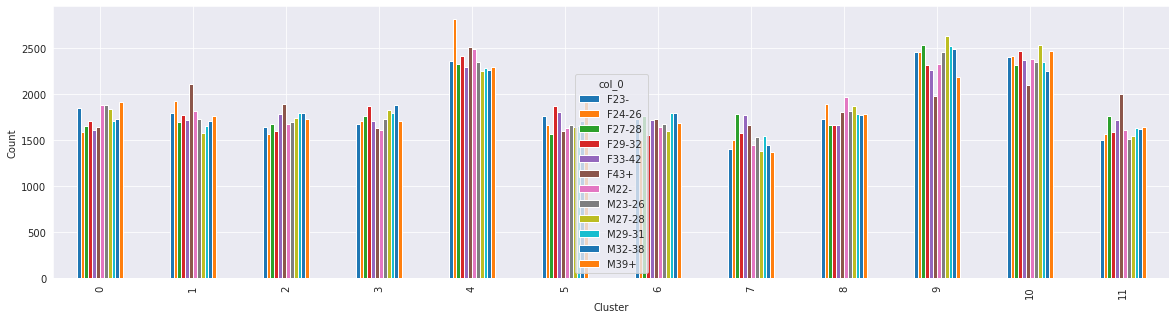

In [0]:
#Show authors categorized by cluster
p_y = pd.crosstab(kmeans_pred, y_train)
p_y.plot(kind='bar', stacked=False, figsize=[20,5])
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

In [0]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances

model = KMeans(n_clusters=12, random_state=42).fit_predict(X_train)


print(metrics.silhouette_score(X_train, model, metric='euclidean'))




0.37761587941482705


In [0]:
#Declare and fit the model.

# need to make smaller due to crashing and using all of ram 
from sklearn.cluster import SpectralClustering

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split

# Create X and y 
X = gender_full_sampled.drop(['group'], axis=1)
Y = gender_full_sampled['group'].values


X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=0)
spectral_pred = SpectralClustering(n_clusters=12).fit_predict(X_train)

#Print cross tab of data vs prediction
print('Comparing Spectral Clusters to Demographic Groups:')
print(pd.crosstab(y_train, spectral_pred))

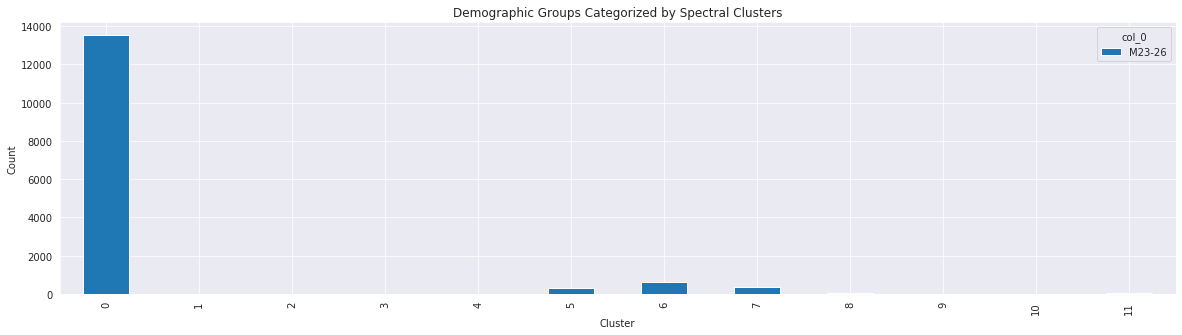

In [0]:
#Show authors categorized by cluster
prediction = pd.crosstab(spectral_pred, y_train)
prediction.plot(kind='bar', stacked=False, figsize=[20,5])
plt.title('Demographic Groups Categorized by Spectral Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# Deep Learning


In [0]:

import tensorflow as tf
import keras

# Import various componenets for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, MaxoutDense
from keras.models import Model
from keras.preprocessing import sequence
from keras.optimizers import RMSprop, Adam, SGD, Adagrad
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization

# Import the backend
from keras import backend as K

In [0]:

# Prepare to encode group since ANN doesn't like string data in y group.
dl_genderfull = gender_full_sampled

# Build numerical labels for our models
groupencoder = LabelEncoder().fit(dl_genderfull['group'])

# Store in a new column
dl_genderfull['encoded_group'] = groupencoder.transform(dl_genderfull['group'])

dl_genderfull.head()

,device_id,gender,age,group,app_id,is_active,encoded_model,label_id,2,4,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,38,...,974,975,976,977,978,980,982,983,984,986,987,988,990,991,993,995,996,997,998,999,1002,1003,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,encoded_group
7654809,6391094174250536901,1,26,M23-26,3722410295315095646,0,857,704,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
10659061,-7924701358100587813,1,26,M23-26,-1596342834117879984,0,863,548,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
8373821,-8930344956501495392,1,23,M23-26,-3943652190894535955,0,1334,407,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
12804025,-7616175892068103491,1,24,M23-26,-653184325010919369,0,1659,251,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
11569255,4585428206812872117,1,26,M23-26,-8271866350659046570,0,735,774,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7


In [0]:
from sklearn.decomposition import PCA

# Recreate the test and training set since encoded group is now the target.
X3 = dl_genderfull.drop(['group'], axis=1)
Y3 = dl_genderfull['encoded_group'].values

# Instantiate StandardScaler 
ss = StandardScaler()

# Set up the variables.
prep_X2 = X3

# Standarize and fit the data first 
stand_x2 = ss.fit_transform(prep_X2)


# Create a new training and testing set
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, Y3, test_size=0.25)

In [0]:
# Start with a simple sequential model.
model = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model.add(Dense(128, activation='elu', input_shape=(492,)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(12, activation='softmax'))


model.summary()

# Compile the model to put it all together.
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               63104     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
batch_normalization_8 (Batch (None, 64)               

In [0]:

history = model.fit(X_train3, y_train3,
                    batch_size=1250,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test3, y_test3))

score = model.evaluate(X_test3, y_test3, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
#Convolutional Neural Network

# Create a smaller data set of the previous encoded group.
X3_mini = X3[:100000]
Y3_mini = Y3[:100000]

# Create a new training and testing set again.
X_train4, X_test4, y_train4, y_test4 = train_test_split(X3_mini, Y3_mini, test_size=0.25)

# Increase the dimensional size of X_train/test_pca
# in order for Conv1d to run smoothly.
X_train_pca_mod = np.expand_dims(X_train4, axis=2)
X_test_pca_mod = np.expand_dims(X_test4, axis=2)

# Encode y into 12 different vectors for CNN.
y_train_CNN = np_utils.to_categorical(y_train4, 12)
y_test_CNN = np_utils.to_categorical(y_test4, 12)

# Building the Convolutionals Model
model = Sequential()

# Set up some parameters
input_dim = 1

# Convert X_train and X_test to numpy array and make sure all sequences
# have the same length.
max_review_length = 500 
X_train_CNN = sequence.pad_sequences(X_train_pca_mod, maxlen=max_review_length) 
X_test_CNN = sequence.pad_sequences(X_test_pca_mod, maxlen=max_review_length)


# First convolutional layer, note the specification of shape
model.add(Conv1D(64, kernel_size=10,
                 padding='same',
                 input_shape=(max_review_length, input_dim),
                 activation='elu',
                 strides=1))
model.add(Conv1D(64, kernel_size=20, activation='elu'))
model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=15, activation='elu'))
model.add(MaxPooling1D(pool_size=15,
                       padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv1D(32, kernel_size=20, activation='elu'))
model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=10, activation='elu'))
model.add(MaxPooling1D(pool_size=25,
                       padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(MaxoutDense(32, nb_feature=12))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxoutDense(32, nb_feature=12))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(MaxoutDense(32, nb_feature=12))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adagrad(),
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 500, 64)           704       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 481, 64)           81984     
_________________________________________________________________
batch_normalization_13 (Batc (None, 481, 64)           256       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 467, 32)           30752     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 32)            0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32)            128       
_________________________________________________________________
dropout_15 (Dropout)         (None, 32, 32)          

In [0]:
model.fit(X_train_CNN, y_train_CNN,
          batch_size=1250,
          epochs=10,
          verbose=1,
          validation_data=(X_test_CNN, y_test_CNN))

score = model.evaluate(X_test_CNN, y_test_CNN, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 75000 samples, validate on 25000 samples
Epoch 1/10
75000/75000 [==============================] - 27s 361us/step - loss: 2.2601 - acc: 0.2541 - val_loss: 1.7637 - val_acc: 0.3030
Epoch 2/10
75000/75000 [==============================] - 21s 275us/step - loss: 1.7246 - acc: 0.2966 - val_loss: 1.5129 - val_acc: 0.3030
Epoch 3/10
75000/75000 [==============================] - 21s 275us/step - loss: 1.5412 - acc: 0.2969 - val_loss: 1.4173 - val_acc: 0.2988
Epoch 4/10
75000/75000 [==============================] - 21s 275us/step - loss: 1.4644 - acc: 0.2982 - val_loss: 1.3790 - val_acc: 0.2994
Epoch 5/10
75000/75000 [==============================] - 21s 275us/step - loss: 1.4314 - acc: 0.3023 - val_loss: 1.3599 - val_acc: 0.3006
Epoch 6/10
75000/75000 [==============================] - 21s 275us/step - loss: 1.4206 - acc: 0.3023 - val_loss: 1.3498 - val_acc: 0.3006
Epoch 7/10
75000/75000 [==============================] - 21s 275us/step - loss: 1.4057 - acc: 0.3007 - val_loss: 1.

# Using PCA

In [0]:
# Prepare to encode group since ANN doesn't like string data in y group.
dl_genderfull = gender_full_sampled

# Build numerical labels for our models
groupencoder = LabelEncoder().fit(dl_genderfull['group'])

# Store in a new column
dl_genderfull['encoded_group'] = groupencoder.transform(dl_genderfull['group'])

dl_genderfull.head()

,device_id,gender,age,group,app_id,is_active,encoded_model,label_id,2,4,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,32,33,35,36,37,38,...,974,975,976,977,978,980,982,983,984,986,987,988,990,991,993,995,996,997,998,999,1002,1003,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,encoded_group
6530707,3815308419818425750,1,23,M23-26,-5305727755345208179,1,129,704,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
6735035,1570955105239258370,1,24,M23-26,-3507529970483852351,0,865,254,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
8718114,-1030061935764942114,1,25,M23-26,1757044000527607662,0,375,1012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,7
10093908,-5641386176120876758,1,26,M23-26,-4986139885405704,0,736,405,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
275162,2957948755409153401,1,23,M23-26,-5720078949152207372,1,1247,721,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7


In [0]:
# Recreate the test and training set since encoded group is now the target.
X3 = resampled2.drop(['group'], axis=1)
Y3 = resampled2['encoded_group'].values

# Instantiate StandardScaler for pca
ss = StandardScaler()

# Set up the variables.
prep_X2 = X3

# Standarize and fit the data first 
stand_x2 = ss.fit_transform(prep_X2)

# Perform PCA on the standardized data. 
#X3_pca = pca.fit_transform(stand_x2)
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(stand_x2)


# Create a new training and testing set
X_train3, X_test3, y_train3, y_test3 = train_test_split(principalComponents, Y3, test_size=0.25)

In [0]:
# Start with a simple sequential model.
model = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model.add(Dense(128, activation='elu', input_shape=(10,)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(12, activation='softmax'))


model.summary()

# Compile the model to put it all together.
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               1408      
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
batch_normalization_8 (Batch (None, 64)               

In [0]:

history = model.fit(X_train3, y_train3,
                    batch_size=1250,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test3, y_test3))

score = model.evaluate(X_test3, y_test3, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 270000 samples, validate on 90000 samples
Epoch 1/20





270000/270000 [==============================] - 11s 42us/step - loss: 1.8614 - acc: 0.2932 - val_loss: 1.3208 - val_acc: 0.4219
Epoch 2/20
270000/270000 [==============================] - 4s 16us/step - loss: 1.3024 - acc: 0.4315 - val_loss: 0.9493 - val_acc: 0.5853
Epoch 3/20
270000/270000 [==============================] - 4s 16us/step - loss: 1.1751 - acc: 0.4850 - val_loss: 0.9430 - val_acc: 0.5929
Epoch 4/20
270000/270000 [==============================] - 4s 16us/step - loss: 1.1125 - acc: 0.5153 - val_loss: 0.9113 - val_acc: 0.5996
Epoch 5/20
270000/270000 [==============================] - 4s 16us/step - loss: 1.0774 - acc: 0.5313 - val_loss: 0.8798 - val_acc: 0.6185
Epoch 6/20
270000/270000 [==============================] - 5s 17us/step - loss: 1.0513 - acc: 0.5439 - val_loss: 0.8716 - val_acc: 0.6134
Epoch 7/20
2

In [0]:
#Convolutional Neural Network


# Recreate the test and training set since encoded group is now the target.
X3 = dl_genderfull.drop(['group'], axis=1)
Y3 = dl_genderfull['encoded_group'].values

# Instantiate StandardScaler for pca
ss = StandardScaler()

# Set up the variables.
prep_X2 = X3

# Standarize and fit the data first 
stand_x2 = ss.fit_transform(prep_X2)

# Perform PCA on the standardized data. 
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(stand_x2)


# Create a new training and testing set again.
X_train4, X_test4, y_train4, y_test4 = train_test_split(principalComponents, Y3, test_size=0.25)

# Increase the dimensional size of X_train/test_pca
# in order for Conv1d to run smoothly.
X_train_pca_mod = np.expand_dims(X_train4, axis=2)
X_test_pca_mod = np.expand_dims(X_test4, axis=2)

# Encode y into 12 different vectors for CNN.
y_train_CNN = np_utils.to_categorical(y_train4, 12)
y_test_CNN = np_utils.to_categorical(y_test4, 12)

# Building the Convolutionals Model
model = Sequential()

# Set up some parameters
input_dim = 1

# Convert X_train and X_test to numpy array and make sure all sequences
# have the same length.
max_review_length = 500 
X_train_CNN = sequence.pad_sequences(X_train_pca_mod, maxlen=max_review_length) 
X_test_CNN = sequence.pad_sequences(X_test_pca_mod, maxlen=max_review_length)


# First convolutional layer, note the specification of shape
model.add(Conv1D(64, kernel_size=10,
                 padding='same',
                 input_shape=(max_review_length, input_dim),
                 activation='elu',
                 strides=1))
model.add(Conv1D(64, kernel_size=20, activation='elu'))
model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=15, activation='elu'))
model.add(MaxPooling1D(pool_size=15,
                       padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv1D(32, kernel_size=20, activation='elu'))
model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=10, activation='elu'))
model.add(MaxPooling1D(pool_size=25,
                       padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(MaxoutDense(32, nb_feature=12))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxoutDense(32, nb_feature=12))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(MaxoutDense(32, nb_feature=12))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adagrad(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 500, 64)           704       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 481, 64)           81984     
_________________________________________________________________
batch_normalization_20 (Batc (None, 481, 64)           256       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 467, 32)           30752     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 32, 32)            0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 32, 32)            128       
_________________________________________________________________
dropout_21 (Dropout)         (None, 32, 32)           

In [0]:
model.fit(X_train_CNN, y_train_CNN,
          batch_size=1250,
          epochs=10,
          verbose=1,
          validation_data=(X_test_CNN, y_test_CNN))

score = model.evaluate(X_test_CNN, y_test_CNN, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 270000 samples, validate on 90000 samples
Epoch 1/10
270000/270000 [==============================] - 77s 284us/step - loss: 2.1951 - acc: 0.1965 - val_loss: 14.7762 - val_acc: 0.0833
Epoch 2/10
270000/270000 [==============================] - 73s 272us/step - loss: 1.7934 - acc: 0.2780 - val_loss: 14.7762 - val_acc: 0.0833
Epoch 3/10
270000/270000 [==============================] - 73s 272us/step - loss: 1.7109 - acc: 0.2938 - val_loss: 14.7762 - val_acc: 0.0833
Epoch 4/10
270000/270000 [==============================] - 74s 273us/step - loss: 1.6723 - acc: 0.3044 - val_loss: 14.7675 - val_acc: 0.0833
Epoch 5/10
270000/270000 [==============================] - 74s 273us/step - loss: 1.6476 - acc: 0.3128 - val_loss: 1.7392 - val_acc: 0.2974
Epoch 6/10
270000/270000 [==============================] - 74s 273us/step - loss: 1.6323 - acc: 0.3155 - val_loss: 14.7762 - val_acc: 0.0833
Epoch 7/10
270000/270000 [==============================] - 74s 272us/step - loss: 1.6205 - acc: 0